In [4]:
import logging
import sys
import numpy as np
import pandas as pd
import polars as pl
import datetime
import polars_ols as pls
from matplotlib import pyplot as plt
from mpl_bsic import apply_bsic_logo, apply_bsic_style
from pypfopt.efficient_frontier import EfficientFrontier

logging.basicConfig(stream=sys.stdout)
log = logging.getLogger("backtester")

In [5]:
def _update_transition_prob_matrix(chain, counts_matrix, lag):
    flat_coords = np.ravel_multi_index((chain[:-lag], chain[lag:]), counts_matrix.shape)
    return np.bincount(flat_coords, minlength=counts_matrix.size).reshape(counts_matrix.shape)

def _convert_to_probabilities(transition_matrix: np.ndarray): 
    M = transition_matrix.copy()
    for row in M: 
        n = sum(row)
        if n > 0: 
            row[:] = [f/n for f in row] 
    
    return M

def compute_transition_matrix(df_with_quantiles: pl.DataFrame, quantile_col: str, n_quantiles: int, lag: int = 1, plot: bool = False):
    """Compute the transition probabilities for quantiles for a given signal, given a certain lag (1 unit of lag is 1 month of time)"""
    
    # group by the cusip, and get the evolution of the quantile during time for each bond
    quantiles_evolution = df_with_quantiles.sort('date').filter(pl.col(quantile_col).is_not_null()).group_by('cusip', maintain_order=True).agg(pl.col(quantile_col))
    
    # initialize the matrix of transition probabilities
    transition_probabilities = np.zeros((n_quantiles, n_quantiles), dtype=np.float64)
    
    # iterate through the different evolutions and update the transition probabilities
    for row in quantiles_evolution.iter_rows(): 
        chain = row[1]
        if np.min(chain) != 0: 
            chain -= np.min(chain)
        
        transition_probabilities[:, :] += _update_transition_prob_matrix(chain, transition_probabilities, lag)
    
    # convert these to actual probabilities
    transition_probabilities = _convert_to_probabilities(transition_probabilities)
    
    if plot: 
        fig, ax = plt.subplots()
        ax.imshow(transition_probabilities, cmap='hot', interpolation='nearest')
    
    return transition_probabilities

In [6]:
bond_data = pl.read_parquet('../../data/final_data/data_with_signals.pq')
bond_data.head()

,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,sic_code,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,size_jk,BOND_YIELD,CS,BONDPRC,PRFULL,CONVEXITY,CS_6M_DELTA,bond_value,BOND_VALUE,coupon,…,spread_duration,bucket,dxs,relative_dxs,systematic_return,residual_return_t+1,oas_bucket_delta,oas_quantile,weighted_dxs_median,weighted_ret_median,oas_bucket_delta_right,oas_quantile_right,carry_signal_val,carry_signal_value,excess_credit_ret,mom_6mo,price_mom_6mo,mom_12mo,price_mom_12mo,price_mom_6mo_bucket_delta,price_mom_6mo_quantile,price_mom_12mo_bucket_delta,price_mom_12mo_quantile,credit_mom_signal_value,ESP_bucket_mean_oas,ESP,esp_residual,esp_residual_bucket_delta,esp_residual_quantile,esp_signal_value,eq_mom_6mo,eq_mom_12mo,eq_mom_6mo_bucket_delta,eq_mom_6mo_quantile,eq_mom_12mo_bucket_delta,eq_mom_12mo_quantile,equity_momentum_signal_value
i64,date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,str,f64,f64,f64,f64,f64,i64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,i64,f64,i64,f64
583213,2012-05-31,"""00037BAA0""",0.006186,0.007551,0.007479,0.006186,null,null,null,6.0,0.010429,null,0.016813,500000.0,500000.0,99.829504,0.998295,60.1,4.723592,11.0,3612,0.004055,0.003489,null,16.0,1.0,1.0,0.017072,0.010567,99.6121,99.715921,25.124045,null,4.9914752e7,4.980605e7,1.625,…,2.787959,"""2_A_shortdur""",0.027666,4.676272,0.003748,0.002438,0.001853,8,0.005916,0.000801,0.001853,8,0.505634,0.505634,null,NaN,NaN,NaN,NaN,null,null,null,null,null,0.008071,0.001853,null,null,null,null,NaN,NaN,null,null,null,null,null
588586,2012-06-30,"""00037BAA0""",0.011728,0.003808,0.004315,0.011728,0.006186,0.006186,0.007479,6.0,0.00888,null,0.015781,500000.0,500000.0,100.447,1.00447,59.1,4.645004,11.0,3612,0.005945,0.014093,null,15.0,1.0,1.0,0.015094,0.008109,100.5391,100.764793,24.445752,null,5.02235e7,5.026955e7,1.625,…,2.363495,"""2_A_shortdur""",0.018979,3.207915,0.002571,0.009157,0.000939,7,0.005916,0.000801,0.000939,7,0.313199,0.313199,0.005302,NaN,NaN,NaN,NaN,null,null,null,null,null,0.007091,0.000939,null,null,null,null,NaN,NaN,null,null,null,null,null
594002,2012-07-31,"""00037BAA0""",-0.001191,-0.002055,-0.001935,-0.001091,0.011728,0.011728,0.004315,6.0,0.00808,null,0.013519,500000.0,500000.0,101.625066,1.016251,58.066667,4.567047,11.0,3612,0.007198,0.019627,null,15.0,1.0,1.0,0.01264,0.00672,101.665,102.03965,23.628646,null,5.0812533e7,5.08325e7,1.625,…,2.400071,"""2_A_shortdur""",0.017051,2.882135,0.00231,-0.003401,0.000514,7,0.005916,0.000801,0.000514,7,0.313199,0.313199,0.00289,NaN,NaN,NaN,NaN,null,null,null,null,null,0.006591,0.000514,null,null,null,null,NaN,NaN,null,null,null,null,null
599442,2012-08-31,"""00037BAA0""",0.002185,0.002064,0.002085,0.002285,-0.001091,-0.001191,-0.001935,6.0,0.008651,null,0.014018,500000.0,500000.0,101.5142,1.015142,57.033333,4.481314,11.0,3612,-0.002496,-0.003326,null,18.0,1.0,1.0,0.012993,0.007078,101.473,101.996612,22.750908,null,5.07571e7,5.07365e7,1.625,…,2.380807,"""2_A_shortdur""",0.017731,2.996963,0.002402,-0.000117,0.000918,7,0.005916,0.000801,0.000918,7,0.313199,0.313199,-0.000224,NaN,NaN,NaN,NaN,null,null,null,null,null,0.006529,0.000918,null,null,null,null,NaN,NaN,null,null,null,null,null
604916,2012-09-30,"""00037BAA0""",0.001884,0.005208,0.004934,0.001984,0.002285,0.002185,0.002085,6.0,0.008276,null,0.01376,500000.0,500000.0,101.746142,1.017461,56.033333,4.400393,11.0,3612,0.003524,0.005008,null,15.0,1.0,1.0,0.012316,0.006696,101.7547,102.400185,22.069816,null,5.0873071e7,5.087735e7,1.625,…,2.1584,"""2_A_shortdur""",0.014568,2.462358,0.001973,0.00001,0.001135,7,0.005916,0.000801,0.001135,7,0.313199,0.313199,0.002127,NaN,NaN,NaN,NaN,null,null,null,null,null,0.005614,0.001135,null,null,null,null,NaN,NaN,

In [112]:
class Backtester:
    def __init__(
        self,
        bond_data: pl.DataFrame,
        halflife: int,
        formation_period_len: int,
    ) -> None:
        
        self.bond_data = bond_data.sort(['cusip', 'date'])   # DataFrame with time series of alpha estimates for each bond   
        self.signals = [f'{signal_name}_signal_value' for signal_name in ['equity_momentum', 'carry', 'credit_mom', 'esp']]
        
        self.formation_period_date = datetime.date(2005,1,1)
        
        self.bonds = bond_data.select('cusip').unique()
        
        # self.factors = ????????? #list of all factor labels
        
        self.formation_period_len = formation_period_len
        
        self.dates = bond_data.select('date').sort('date').unique()
        self.end_formation_date = self.dates[formation_period_len]
        
        self.half_life = halflife
        
        self.alpha = 1 - np.exp(-np.log(2) / self.half_life)   
        
    def _compute_partial_returns(self, to_date: datetime.date):
        data = self.bond_data.filter(pl.col('date') < to_date)
        signals = self.signals
        signals_cols = [pl.col(signal) for signal in signals]
        
        partial_returns = data.select(
            pl.col('date'),
            pl
            .col('residual_return_t+1')
            .least_squares.ols(*signals_cols, add_intercept=False, mode='coefficients', null_policy='drop')
            .over('date')
        ).unnest('coefficients')
        
        return partial_returns
    
    def compute_signal_weights(self) -> pl.DataFrame:
        # initialize variables
        alpha = self.alpha
        signals = self.signals
        formation_date = self.formation_period_date
        print(f'using alpha={alpha}')
        
        # compute partial returns during the formation period
        partial_returns_formation_period = self._compute_partial_returns(formation_date)
        
        # calculate partial return volatility
        dates = self.bond_data.filter(pl.col('date') >= formation_date).get_column('date').unique()
        v_0 = partial_returns_formation_period.drop('date').std() # compute volatility at time 0 as a starting point
        
        pr_volatilities = np.zeros((len(dates), len(self.signals)))
        signal_weights = np.zeros((len(dates), len(self.signals)))
                                  
        pr_volatilities[0] = v_0.to_numpy()[0]  # initialize with the volatility from the formation period
        # TODO SUBSTITUTE WITH FAMA-MACBETH LOADINGS
        partial_returns_t_0 = partial_returns_formation_period.drop('date')[-1].to_numpy()[0]
        signal_weights[0] = partial_returns_t_0 / np.sum(partial_returns_t_0)
        
        j = 0
        for i in range(1,len(dates)):
            j += 1
            if j % 50 == 0: 
                print(f'j={j}, {j/len(dates)*100:.2f}%')
            date = dates[i]
            
            partial_rets = self._compute_partial_returns(date)
            r_t = partial_rets.drop('date')[-1].to_numpy()[0]
            
            pr_volatilities[i] = (1-alpha) * pr_volatilities[i-1] + alpha * np.power(r_t, 2)
            signal_weights[i] = (1-alpha) * signal_weights[i-1] + alpha * r_t / pr_volatilities[i]
            
        signal_weights = signal_weights / signal_weights.sum(axis=1).reshape(-1,1)
        signal_weights = pl.DataFrame(signal_weights).rename({f'column_{i}': signals[i] for i in range(len(signals))}).with_columns(
            date=dates
        )
        
        # rename columns to weights
        signal_weights = signal_weights.rename({col: col.replace('value', 'weight') for col in signals})
            
        return signal_weights
       
    def compute_alpha_estimates(self): 
        bond_data, formation_date, signals = self.bond_data, self.formation_period_date ,self.signals
        signal_weights = self.compute_signal_weights()
        
        df = bond_data.filter(pl.col('date') >= formation_date).join(
            signal_weights,
            how='left',
            on='date'
        )
        
        condition = pl.any_horizontal(pl.col(*signals).is_null())
        
        df = df.with_columns(
            composite_signal=pl.when(condition).then(None).otherwise(pl.col('carry_signal_weight') * pl.col('carry_signal_value') + pl.col('credit_mom_signal_weight') * pl.col('credit_mom_signal_value') + pl.col('esp_signal_weight') * pl.col('esp_signal_value') + pl.col('equity_momentum_signal_weight') * pl.col('equity_momentum_signal_value')
            )
        )
        
        return df
    
    def compute_quantiles(self, df: pl.DataFrame, col: str, n_quantiles: int):
        """Divide the cols in quantiles based on the bucket groups"""
        quantile_col_name = f'{col}_quantile'
        
        # create the bins and labels to be used in qcut
        bins = np.linspace(0,1,n_quantiles+1)[1:]
        labels = [str(i+1) for i in range(n_quantiles+1)]
        
        data = []
        for group in df.select('date').unique().iter_rows():
            date = group[0]
            
            group_data = df.filter((pl.col('date') == date) & (pl.col(col).is_not_null())).select('cusip', 'date', col)
    
            # if the DataFrame is emtpy just continue, otherwise qcut will throw an error
            if group_data.shape[0] == 0:
                continue
            
            group_data = group_data.with_columns(
                pl.col(col).qcut(bins,labels=labels, allow_duplicates=True).alias(quantile_col_name)
            )
                
            data.append(group_data)
            
        print('... done!')
        
        quantiles = pl.concat(data, how='vertical')
        quantiles = quantiles.with_columns(
            pl.col(quantile_col_name).cast(int).alias(quantile_col_name)
        )
        return df.join(quantiles.drop('bucket'), how='left', on=['date', 'cusip'])
    
    def get_mvo_weights(self, cusips: list[str], date: datetime.date):
        bonds_data = self.bond_data.filter((pl.col('cusip').is_in(cusips)) & (pl.col('date') <= date))
        
        # bonds_data_pd = bonds_data.select('cusip', 'date', 'bond_ret').to_pandas()
        # covariance_matrix = bonds_data_pd.pivot(columns='cusip', values='bond_ret', index='date').sort_values('date').cov()
        # print(covariance_matrix)
        # 
        # return covariance_matrix, bonds_data_pd
        # 
        # efficient_frontier = EfficientFrontier(None, covariance_matrix)
        # optimal_weights = efficient_frontier.min_volatility()
        # 
        # return optimal_weights
        
        return bonds_data.with_columns(
            weight=(1/pl.col('cusip').n_unique())
        ).select('cusip', 'weight')
    
    def run(
        self,
    ):
        bond_data = self.bond_data
        alpha_estimates = self.compute_alpha_estimates()
        quantiles = self.compute_quantiles(alpha_estimates, 'composite_signal', 10)
        
        portfolio_weights = pd.DataFrame(
            columns=quantiles.get_column('cusip').unique())
        
        for date in quantiles.sort('date').select('date').unique().iter_rows(): 
            date = date[0]
            data = quantiles.filter(pl.col('date') == date)
            bonds = data.filter(pl.col('composite_signal_quantile') == 10)
                
            bonds = bonds.sort('composite_signal_quantile')
            
            # pick the top 25 bonds
            cusips = bonds[:25].get_column('cusip').unique().to_list()
            
            weights = self.get_mvo_weights(cusips, date)
            
            for row in weights.iter_rows(named=True):
                cusip = row['cusip']
                weight = row['weight']
                
                portfolio_weights.loc[date, cusip] = weight
                
        # compute portfolio asset_returns
        asset_returns = bond_data.select('cusip', 'date', 'bond_ret_t+1').to_pandas()
        asset_returns = asset_returns.pivot(index='date', columns='cusip', values='bond_ret_t+1').reindex(portfolio_weights.columns, axis=1)
        
        portfolio_returns = (asset_returns * portfolio_weights).sum(axis=1)
        
        return portfolio_returns

In [113]:
backtester = Backtester(bond_data, 12, 2)

In [114]:
returns = backtester.run()

using alpha=0.05612568731830647
j=50, 41.67%
j=100, 83.33%
... done!


sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


In [123]:
returns = returns[returns.index >= pd.to_datetime('2005-1-1')]

In [124]:
returns.mean() / returns.std() * np.sqrt(12)

2.5020439785224218

In [133]:
mkt = pd.read_excel('../../data/indices/barclays_aggregate_global.xlsx')
mkt.head()
mkt = mkt.set_index('Date').reindex(returns.index)
mkt['cumret'] = mkt['Change'].add(1).cumprod()

<Axes: >

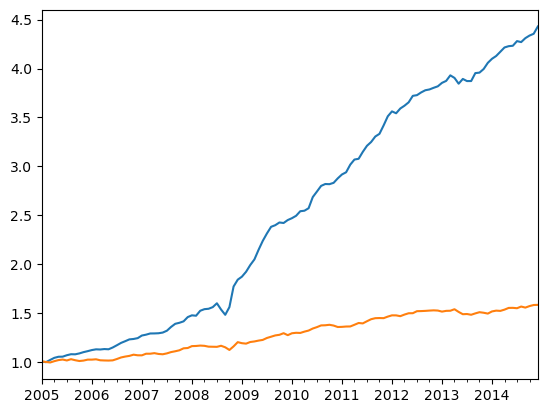

In [134]:
returns.add(1).cumprod().plot()
mkt['cumret'].plot()

Given weights calculate returns and portfolio evolution ( returns)
 
 Formation period: 48 months to compute initial weights
    Cross sectional regression of residual returns on all signals ---> coefficients are partial returns
    Partial returns are optimal ex-post weights to estimate composite alpha
    Compute average weights in the formation period and signal volatilities
 
 Timing signals: exponential smoothing to compute weights
    Set half life and compute alpha
    For each month compute volatility and weight for each signal
    
 Portfolio contruction: Markowitz with composite alpha as return
 
 Strategy evaluation
 
 """

# Backtest

What we have

- Bond prices & returns 
- Signal values (quantiles) & alpha estimates for each time period

What we have to do

- Compute the weights at each point in time for the signals
- Compute the composite signal 
- Weight the instruments with Markowitz
- weights @ returns and we have the portfolio performance

Things to consider

- Turnover limits -> include in markowitz as a constraint
- The fact that we may want to have x% of the portfolio invested in the index, and just go overweight some bonds

Bonus

- Barclays also considers alpha decay